## notebook testing blob radius extraction ideas

Need a metric to quantify its success

In [5]:
import sys,os,os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append("../")
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
os.environ['ICTDIR']='/home/e78368jw/Documents/NEXT_CODE/IC'

from invisible_cities.core.core_functions   import shift_to_bin_centers
from invisible_cities.io.dst_io             import load_dst, load_dsts, df_writer
from invisible_cities.io.hits_io            import hits_from_df
from invisible_cities.reco                  import paolina_functions as plf
from invisible_cities.types.ic_types        import         types_dict_tracks
from invisible_cities.types.symbols         import                 HitEnergy
from invisible_cities.evm.event_model       import             HitCollection
from invisible_cities.core                  import system_of_units as units

from typing import Tuple, Callable

import core.plotting_functions as plt_func


## lets create the blob info creator extractor from scratch

In [6]:
# output the accuracy of the blob positions
def output_inaccuracy(df, df_MC):

    RECO_b1_xyz = np.column_stack([df.blob1_x[0], df.blob1_y[0], df.blob1_z[0]])
    RECO_b2_xyz = np.column_stack([df.blob2_x[0], df.blob2_y[0], df.blob2_z[0]])

    MC_b1_xyz = np.column_stack([df_MC.blob1_x[0], df_MC.blob1_y[0], df_MC.blob1_z[0]])
    MC_b2_xyz = np.column_stack([df_MC.blob2_x[0], df_MC.blob2_y[0], df_MC.blob2_z[0]])


    dist_b1 = np.linalg.norm((RECO_b1_xyz) - (MC_b1_xyz))
    dist_b2 = np.linalg.norm((RECO_b2_xyz) - (MC_b2_xyz))
    print(f"Blob 1 RECO/MC distance: {dist_b1:.2f}mm")
    print(f"Blob 2 RECO/MC distance: {dist_b2:.2f}mm")



def track_blob_info_creator_extractor(vox_size         : Tuple[float, float, float],
                                      strict_vox_size  : bool                      ,
                                      energy_threshold : float                     ,
                                      min_voxels       : int                       ,
                                      blob_radius      : float                     ,
                                      max_num_hits     : int
                                     ) -> Callable:
    """
    For a given paolina parameters returns a function that extract tracks / blob information from a HitCollection.

    Parameters
    ----------
    vox_size         : [float, float, float]
        (maximum) size of voxels for track reconstruction
    strict_vox_size  : bool
        if False allows per event adaptive voxel size,
        smaller of equal thatn vox_size
    energy_threshold : float
        if energy of end-point voxel is smaller
        the voxel will be dropped and energy redistributed to the neighbours
    min_voxels       : int
        after min_voxel number of voxels is reached no dropping will happen.
    blob_radius      : float
        radius of blob

    Returns
    ----------
    A function that from a given HitCollection returns a pandas DataFrame with per track information.
    """
    def create_extract_track_blob_info(hitc):
        df = pd.DataFrame(columns=list(types_dict_tracks.keys()))
        if len(hitc.hits) > max_num_hits:
            return df, hitc, True
        #track_hits is a new Hitcollection object that contains hits belonging to tracks, and hits that couldnt be corrected
        track_hitc = HitCollection(hitc.event, hitc.time)
        out_of_map = np.any(np.isnan([h.Ep for h in hitc.hits]))
        if out_of_map:
            #add nan hits to track_hits, the track_id will be -1
            track_hitc.hits.extend  ([h for h in hitc.hits if np.isnan   (h.Ep)])
            hits_without_nan       = [h for h in hitc.hits if np.isfinite(h.Ep)]
            #create new Hitcollection object but keep the name hitc
            hitc      = HitCollection(hitc.event, hitc.time)
            hitc.hits = hits_without_nan

        hit_energies = np.array([getattr(h, HitEnergy.Ep.value) for h in hitc.hits])

        if len(hitc.hits) > 0 and (hit_energies>0).any():
            voxels           = plf.voxelize_hits(hitc.hits, vox_size, strict_vox_size, HitEnergy.Ep)
            (    mod_voxels,
             dropped_voxels) = plf.drop_end_point_voxels(voxels, energy_threshold, min_voxels)

            for v in dropped_voxels:
                track_hitc.hits.extend(v.hits)

            tracks = plf.make_track_graphs(mod_voxels)
            tracks = sorted(tracks, key=plf.get_track_energy, reverse=True)

            vox_size_x = voxels[0].size[0]
            vox_size_y = voxels[0].size[1]
            vox_size_z = voxels[0].size[2]
            del(voxels)

            track_hits = []
            for c, t in enumerate(tracks, 0):
                tID = c
                energy = plf.get_track_energy(t)
                numb_of_hits   = len([h for vox in t.nodes() for h in vox.hits])
                numb_of_voxels = len(t.nodes())
                numb_of_tracks = len(tracks   )
                pos   = [h.pos for v in t.nodes() for h in v.hits]
                x, y, z = map(np.array, zip(*pos))
                r = np.sqrt(x**2 + y**2)

                e     = [h.Ep for v in t.nodes() for h in v.hits]
                ave_pos = np.average(pos, weights=e, axis=0)
                ave_r   = np.average(r  , weights=e, axis=0)
                distances = plf.shortest_paths(t)
                extr1, extr2, length = plf.find_extrema_and_length(distances)
                extr1_pos = extr1.XYZ
                extr2_pos = extr2.XYZ

                e_blob1, e_blob2, hits_blob1, hits_blob2, blob_pos1, blob_pos2 = plf.blob_energies_hits_and_centres(t, blob_radius)

                overlap = float(sum(h.Ep for h in set(hits_blob1).intersection(set(hits_blob2))))
                list_of_vars = [hitc.event, tID, energy, length, numb_of_voxels,
                                numb_of_hits, numb_of_tracks,
                                min(x), min(y), min(z), min(r), max(x), max(y), max(z), max(r),
                                *ave_pos, ave_r, *extr1_pos,
                                *extr2_pos, *blob_pos1, *blob_pos2,
                                e_blob1, e_blob2, overlap,
                                vox_size_x, vox_size_y, vox_size_z]

                df.loc[c] = list_of_vars

                for vox in t.nodes():
                    for hit in vox.hits:
                        hit.track_id = tID
                        track_hits.append(hit)

            #change dtype of columns to match type of variables
            df = df.apply(lambda x : x.astype(types_dict_tracks[x.name]))
            track_hitc.hits.extend(track_hits)
        return df, track_hitc, out_of_map

    return create_extract_track_blob_info


## load in data

In [ ]:
# load in RECO hits, and true hits
path = '../data/MC/'
# find .h5 files in path
files = [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.h5')]
RECO_hits = load_dst(f'{files[0]}', 'RECO', 'Events')
MC_hits = load_dst(f'{files[0]}', 'MC', 'hits')
part_info = load_dst(f'{files[0]}', 'MC', 'particles')
# particle data too

display(RECO_hits)
display(MC_hits)
display(part_info)


FileNotFoundError: [Errno 2] No such file or directory: 'data/MC/'

## select event, and check it

In [ ]:
# select event
n = 0

MC_evt   = MC_hits[MC_hits.event_id     == MC_hits.event_id.unique()[n]]
RECO_evt = RECO_hits[RECO_hits.event    == RECO_hits.event.unique()[n]]
prt_evt  = part_info[part_info.event_id == part_info.event_id.unique()[n]]

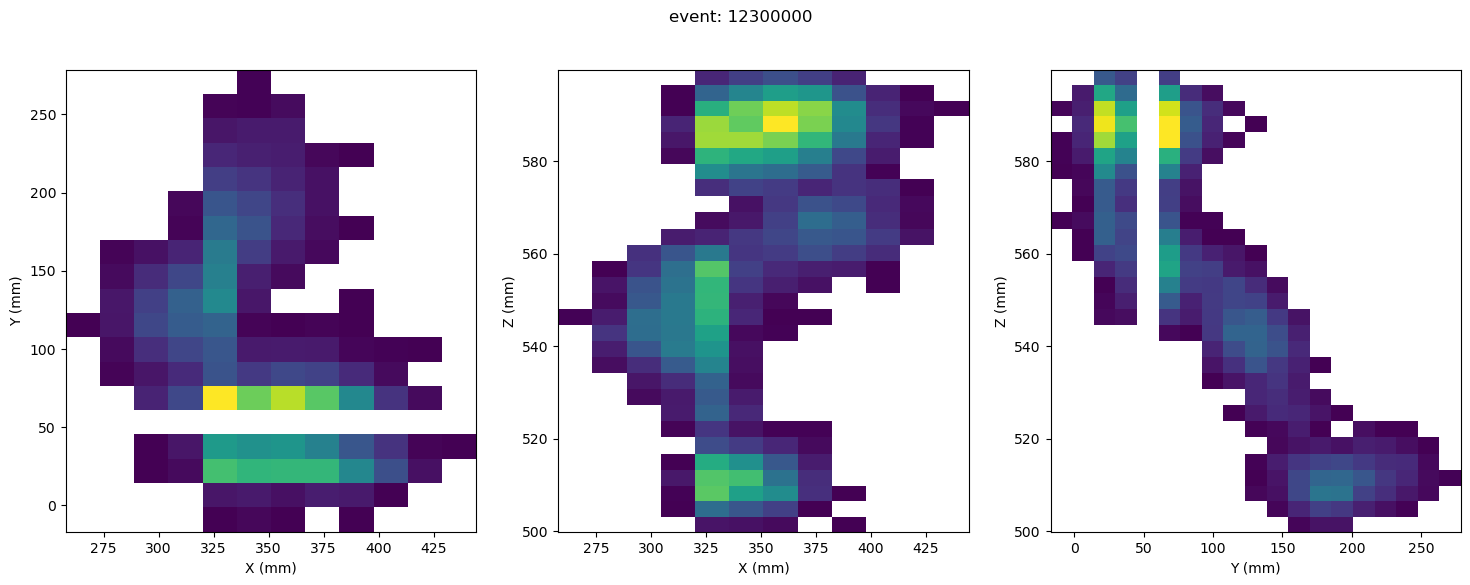

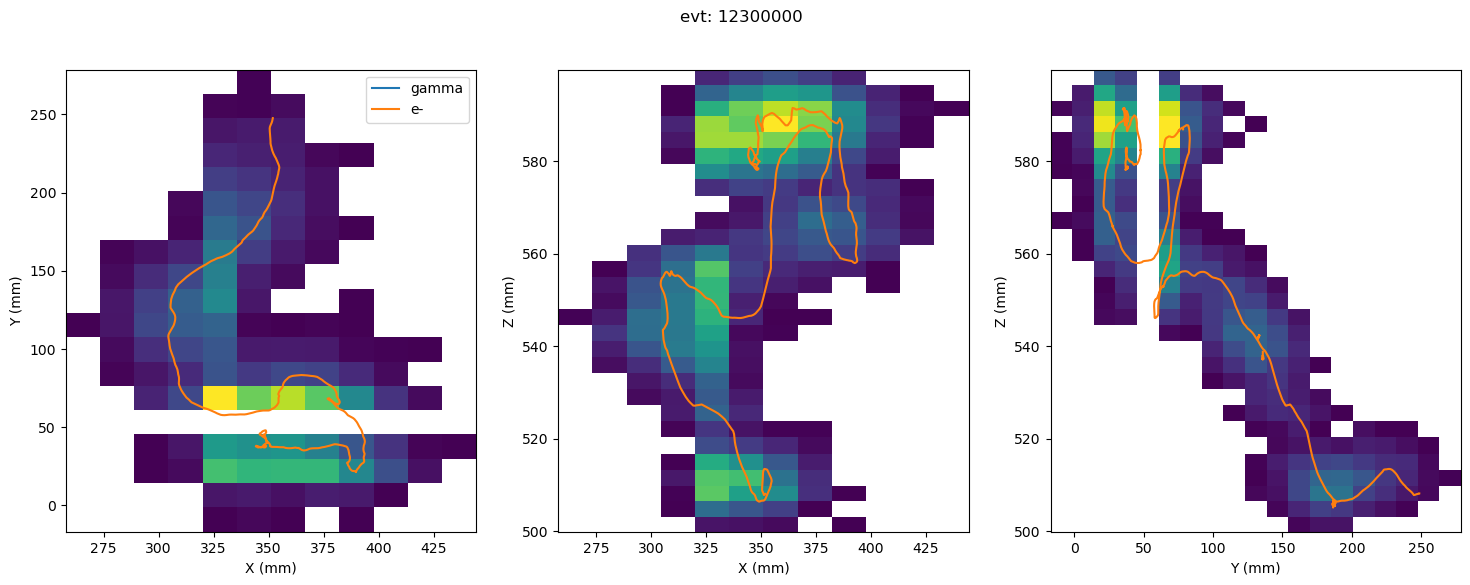

In [ ]:
# display event
plt_func.raw_plotter(RECO_evt, RECO_evt.event.unique()[0])
#plt_func.raw_plotter(MC_evt, MC_evt.event_id.unique()[0], MC = True)
plt_func.plot_MC_over_hits(RECO_evt, MC_evt, prt_evt, MC_evt.event_id.unique()[0])

## set up topology extraction

Both:
- MC hits (small voxelisation)
- RECO hits (larger voxelisation)

In [ ]:
voxel_size_RECO       = 18 * units.mm
blob_radius_RECO      = 45 * units.mm
scan_radius_RECO      = 60 * units.mm

voxel_size_MC         = 6  * units.mm
blob_radius_MC        = 27 * units.mm
scan_radius_MC        = 40 * units.mm

# topological creation
topological_creator_RECO = track_blob_info_creator_extractor((voxel_size_RECO, voxel_size_RECO, voxel_size_RECO),
                                                        False,
                                                        0 * units.keV,
                                                        0,
                                                        blob_radius_RECO,
                                                        10000000000,
                                                        #scan_radius = scan_radius_RECO
                                                        )

topological_creator_MC = track_blob_info_creator_extractor((voxel_size_MC, voxel_size_MC, voxel_size_MC),
                                                        False,
                                                        0 * units.keV,
                                                        0,
                                                        blob_radius_MC,
                                                        10000000000,
                                                        #scan_radius = scan_radius_MC
                                                        )

In [ ]:
display(MC_evt)
MC_untouched_evt = MC_evt.copy(deep = True)
RECO_untouched_evt = RECO_evt.copy(deep = True)

,event_id,particle_id,hit_id,x,y,z,time,energy,label
0,12300000,39,0,352.022552,248.544846,508.099854,0.566156,0.000154,ACTIVE
1,12300000,46,0,352.022736,248.544662,508.099945,0.566252,0.000021,ACTIVE
2,12300000,45,0,352.022461,248.544876,508.099915,0.566188,0.000034,ACTIVE
3,12300000,44,0,352.022552,248.545090,508.099792,0.566248,0.000023,ACTIVE
4,12300000,43,0,352.022614,248.544830,508.099670,0.566254,0.000010,ACTIVE
...,...,...,...,...,...,...,...,...,...
1084,12300000,40,605,347.965912,38.560055,578.603882,2.619068,0.001368,ACTIVE
1085,12300000,40,606,347.966278,38.559826,578.603943,2.619095,0.000246,ACTIVE
1086,12300000,40,607,347.966522,38.559685,578.603943,2.619115,0.000022,ACTIVE
1087,12300000,40,608,347.966736,38.559547,578.604004,2.619135,0.000380,ACTIVE


In [ ]:
if 'Ec' in RECO_evt.columns:
        RECO_evt['Ep'] = RECO_evt['Ec']
else:
        raise KeyError("RECO_evt does not contain column 'Ec'")

hits_RECO = hits_from_df(RECO_evt)




/tmp/ipykernel_20647/1159503685.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RECO_evt['Ep'] = RECO_evt['Ec']


In [ ]:

# reshape the MC, this will only work once!
MC_evt.rename(columns={'x': 'X', 'y': 'Y', 'z': 'Z', 'energy': 'E', 'event_id' : 'event'}, inplace=True)
MC_evt['npeak'] = 1
reshaped_hits = MC_evt.rename(columns={'E': 'Ep'}).assign(Q=1)[['event', 'npeak', 'X', 'Y', 'Z', 'Q', 'Ep']]
reshaped_hits['E'] = reshaped_hits.Ep
display(reshaped_hits)

hits_MC   = hits_from_df(reshaped_hits)

/home/e78368jw/anaconda3/envs/IC-3.8-2022-04-13/lib/python3.8/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/tmp/ipykernel_20647/2464040654.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MC_evt['npeak'] = 1


,event,npeak,X,Y,Z,Q,Ep,E
0,12300000,1,352.022552,248.544846,508.099854,1,0.000154,0.000154
1,12300000,1,352.022736,248.544662,508.099945,1,0.000021,0.000021
2,12300000,1,352.022461,248.544876,508.099915,1,0.000034,0.000034
3,12300000,1,352.022552,248.545090,508.099792,1,0.000023,0.000023
4,12300000,1,352.022614,248.544830,508.099670,1,0.000010,0.000010
...,...,...,...,...,...,...,...,...
1084,12300000,1,347.965912,38.560055,578.603882,1,0.001368,0.001368
1085,12300000,1,347.966278,38.559826,578.603943,1,0.000246,0.000246
1086,12300000,1,347.966522,38.559685,578.603943,1,0.000022,0.000022
1087,12300000,1,347.966736,38.559547,578.604004,1,0.000380,0.000380


In [ ]:
# apply topological result.
for evt in hits_RECO.keys():
        df, track_hitc, out_of_map = topological_creator_RECO(hits_RECO[evt])

for evt in hits_MC.keys():
        df_MC, track_hitc_MC, out_of_map_MC = topological_creator_MC(hits_MC[evt])


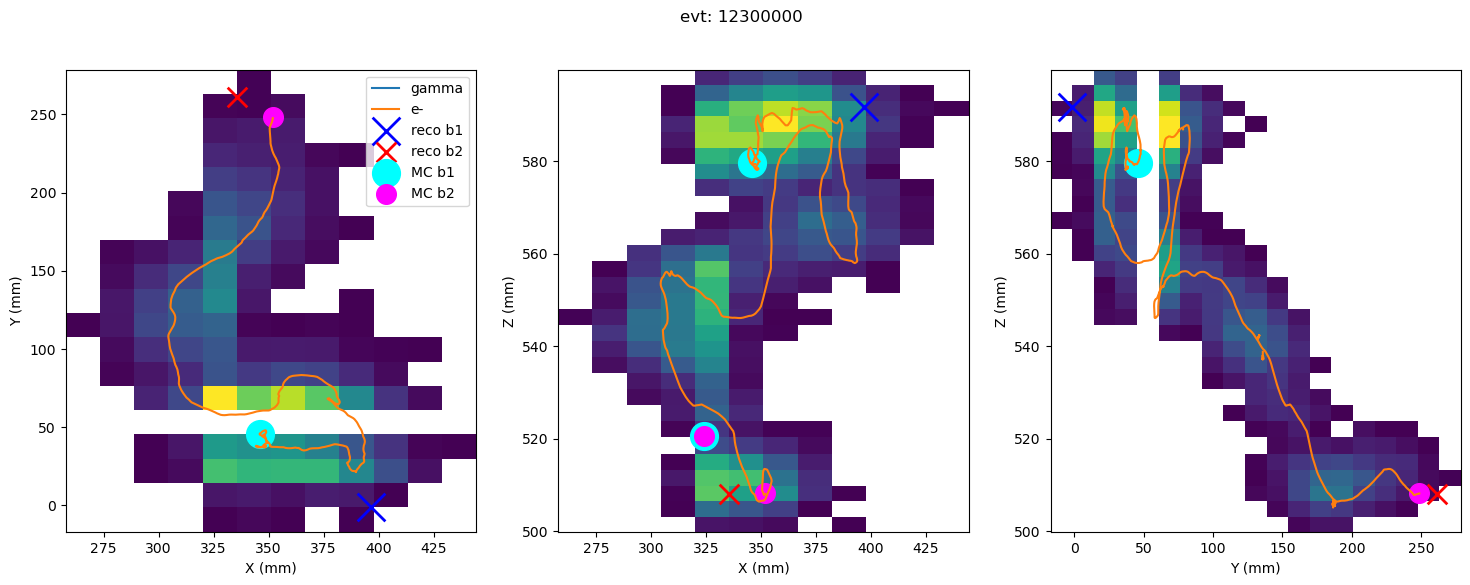

Blob 1 RECO/MC distance: 70.39mm
Blob 2 RECO/MC distance: 20.66mm


In [ ]:

plt_func.plot_MC_over_hits(RECO_untouched_evt, MC_untouched_evt, prt_evt, MC_untouched_evt.event_id.unique()[0], blob_info = (df, df_MC))
output_inaccuracy(df, df_MC)